# Phase 3: Student Performance Prediction Models

**OULAD Learning Analytics Project**

This notebook implements Phase 3 of the dissertation project:
- Load processed and clustered dataset from Phases 1 & 2
- Prepare features and target for prediction
- Implement and train multiple classification models:
  - Decision Tree
  - Random Forest
  - XGBoost
  - LightGBM
- Evaluate models with multiple metrics (Accuracy, F1, Precision, Recall, ROC-AUC)
- Compare model performance
- Analyze feature importance
- Save best models for deployment

---

## 1. Setup and Imports

In [1]:
import sys
import warnings
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, 
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc
)

import xgboost as xgb
import lightgbm as lgb

warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Add src to path
sys.path.append(str(Path.cwd().parent))

print("Setup complete!")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"sklearn version: {__import__('sklearn').__version__}")
print(f"xgboost version: {xgb.__version__}")
print(f"lightgbm version: {lgb.__version__}")

Setup complete!
pandas version: 2.3.3
numpy version: 2.0.1
sklearn version: 1.7.2
xgboost version: 3.0.1
lightgbm version: 4.6.0


/home/galym/miniconda3/envs/env/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


## 2. Load Data

In [2]:
# Data directories
DATA_DIR = Path('../data')
PROCESSED_DIR = DATA_DIR / 'processed' / 'oulad'
MODELS_DIR = Path('../models')
MODELS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR = Path('../figures')

# Load dataset with clusters from Phase 2
df = pd.read_csv(PROCESSED_DIR / 'oulad_with_clusters.csv')

print(f"Loaded dataset: {df.shape}")
print(f"Columns: {len(df.columns)}")
print(f"\nFirst few columns: {df.columns.tolist()[:15]}")

Loaded dataset: (32593, 49)
Columns: 49

First few columns: ['code_module', 'code_presentation', 'id_student', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability', 'final_result', 'student_course_id', 'total_clicks', 'clicks_dataplus']


## 3. Data Preparation

### 3.1 Target Variable

We'll predict the **final_result** (Pass, Fail, Withdrawn, Distinction)

Target distribution (final_result):
final_result
Pass           12361
Withdrawn      10156
Fail            7052
Distinction     3024
Name: count, dtype: int64

Percentage:
final_result
Pass           37.925321
Withdrawn      31.160065
Fail           21.636548
Distinction     9.278066
Name: proportion, dtype: float64


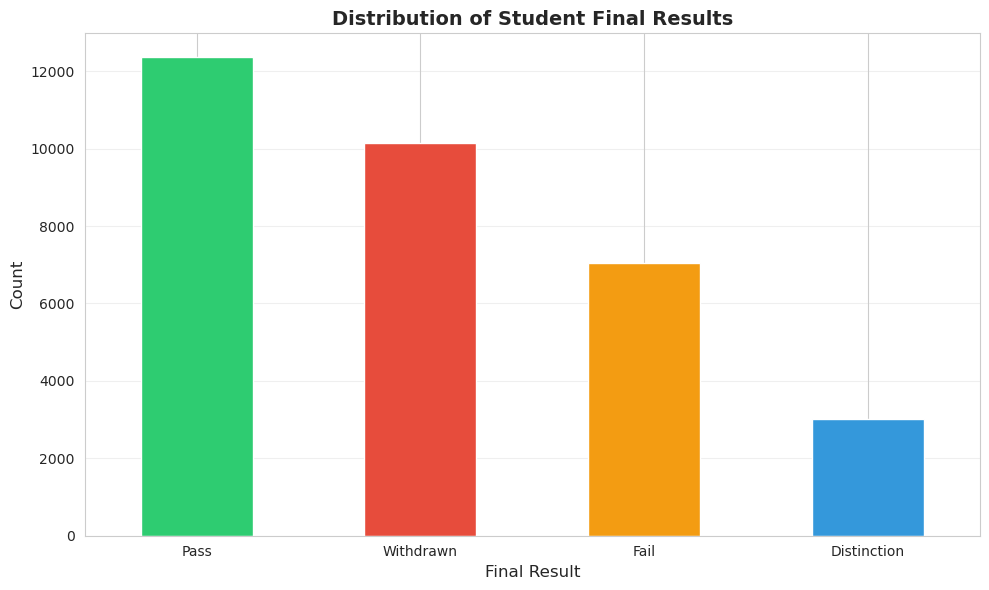


Figure saved: 12_target_distribution.png


In [3]:
# Check target distribution
print("Target distribution (final_result):")
print(df['final_result'].value_counts())
print(f"\nPercentage:")
print(df['final_result'].value_counts(normalize=True) * 100)

# Visualize target distribution
plt.figure(figsize=(10, 6))
df['final_result'].value_counts().plot(kind='bar', color=['#2ecc71', '#e74c3c', '#f39c12', '#3498db'])
plt.xlabel('Final Result', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Student Final Results', fontsize=14, fontweight='bold')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / '12_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFigure saved: 12_target_distribution.png")

### 3.2 Feature Selection

Select features for prediction (exclude target and identifiers)

In [4]:
# Exclude columns that should not be used as features
exclude_columns = [
    'id_student',           # Student ID
    'final_result',         # Target variable
    'code_module',          # Module code (too specific)
    'code_presentation',    # Presentation code (too specific)
    'student_course_id',    # Unique composite ID (creates explosion of features!)
]

# Select feature columns
feature_columns = [col for col in df.columns if col not in exclude_columns]

print(f"Total features: {len(feature_columns)}")
print(f"\nFeature columns:")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i:2d}. {col}")

Total features: 44

Feature columns:
   1. gender
   2. region
   3. highest_education
   4. imd_band
   5. age_band
   6. num_of_prev_attempts
   7. studied_credits
   8. disability
   9. total_clicks
  10. clicks_dataplus
  11. clicks_dualpane
  12. clicks_externalquiz
  13. clicks_folder
  14. clicks_forumng
  15. clicks_glossary
  16. clicks_homepage
  17. clicks_htmlactivity
  18. clicks_oucollaborate
  19. clicks_oucontent
  20. clicks_ouelluminate
  21. clicks_ouwiki
  22. clicks_page
  23. clicks_questionnaire
  24. clicks_quiz
  25. clicks_repeatactivity
  26. clicks_resource
  27. clicks_sharedsubpage
  28. clicks_subpage
  29. clicks_url
  30. num_unique_activities
  31. avg_assessment_score
  32. num_assessments_submitted
  33. total_assessments
  34. assessment_submission_rate
  35. avg_score_TMA
  36. avg_score_CMA
  37. avg_score_Exam
  38. date_unregistration
  39. did_unregister
  40. clicks_per_activity
  41. gender_M
  42. disability_Y
  43. kmeans_cluster
  44. dbsc

### 3.3 Encode Categorical Variables

In [5]:
# Create a copy for modeling
df_model = df[feature_columns + ['final_result']].copy()

# Identify categorical columns
categorical_columns = df_model.select_dtypes(include=['object']).columns.tolist()
if 'final_result' in categorical_columns:
    categorical_columns.remove('final_result')  # Don't encode target yet

print(f"Categorical columns ({len(categorical_columns)}):")
for col in categorical_columns:
    n_unique = df_model[col].nunique()
    print(f"  - {col}: {n_unique} unique values")
    
    # Safety check: warn if high cardinality
    if n_unique > 100:
        print(f"    ⚠️  WARNING: High cardinality! This will create {n_unique} dummy variables.")

# One-hot encode categorical features
print(f"\nOne-hot encoding categorical features...")
df_encoded = pd.get_dummies(df_model, columns=categorical_columns, drop_first=True)

print(f"\n✅ Dataset shape after encoding: {df_encoded.shape}")
print(f"   Features created: {df_encoded.shape[1] - 1}")  # -1 for target column

Categorical columns (6):
  - gender: 2 unique values
  - region: 13 unique values
  - highest_education: 5 unique values
  - imd_band: 10 unique values
  - age_band: 3 unique values
  - disability: 2 unique values

One-hot encoding categorical features...

✅ Dataset shape after encoding: (32593, 68)
   Features created: 67


### 3.4 Encode Target Variable

In [24]:
# Encode target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_encoded['final_result'])

# Get feature matrix
X = df_encoded.drop('final_result', axis=1)

# Store class names for later use
class_names = label_encoder.classes_

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nClass encoding:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {i}")

# Check for missing values
missing_count = X.isnull().sum().sum()
print(f"\nMissing values in X: {missing_count}")
print(f"Missing values in y: {pd.Series(y).isnull().sum()}")

# Handle missing values if present
if missing_count > 0:
    print(f"\n⚠️  Found {missing_count} missing values. Filling with appropriate values...")
    
    # Simple approach: fill all NaN values with median for numeric, 0 for others
    # First fill numeric columns with median
    X = X.fillna(X.median(numeric_only=True))
    
    # Then fill any remaining NaN with 0 (for any non-numeric columns)
    X = X.fillna(0)
    
    print(f"✅ Missing values handled. New count: {X.isnull().sum().sum()}")

Feature matrix shape: (32593, 67)
Target vector shape: (32593,)

Class encoding:
  Distinction: 0
  Fail: 1
  Pass: 2
  Withdrawn: 3

Missing values in X: 59705
Missing values in y: 0

⚠️  Found 59705 missing values. Filling with appropriate values...
✅ Missing values handled. New count: 0


### 3.5 Train/Test Split

In [25]:
# Split data into train and test sets
# Use stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

print(f"\nTraining set class distribution:")
train_dist = pd.Series(y_train).value_counts(normalize=True).sort_index()
for i, pct in train_dist.items():
    print(f"  {class_names[i]}: {pct*100:.1f}%")

print(f"\nTest set class distribution:")
test_dist = pd.Series(y_test).value_counts(normalize=True).sort_index()
for i, pct in test_dist.items():
    print(f"  {class_names[i]}: {pct*100:.1f}%")

# Convert to numpy arrays for XGBoost/LightGBM compatibility
# This avoids the DataFrame dtype attribute error
print(f"\nConverting to numpy arrays for model compatibility...")
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train
y_test_np = y_test

print(f"✅ Conversion complete!")

Training set: (26074, 67)
Test set: (6519, 67)

Training set class distribution:
  Distinction: 9.3%
  Fail: 21.6%
  Pass: 37.9%
  Withdrawn: 31.2%

Test set class distribution:
  Distinction: 9.3%
  Fail: 21.6%
  Pass: 37.9%
  Withdrawn: 31.2%

Converting to numpy arrays for model compatibility...
✅ Conversion complete!


## 4. Model Training

### 4.1 Decision Tree Classifier

In [26]:
print("="*80)
print("DECISION TREE CLASSIFIER")
print("="*80)

# Train Decision Tree
dt_model = DecisionTreeClassifier(
    max_depth=15,
    min_samples_split=100,
    min_samples_leaf=50,
    random_state=42
)

print("\nTraining Decision Tree...")
dt_model.fit(X_train_np, y_train_np)

# Predictions
y_train_pred_dt = dt_model.predict(X_train_np)
y_test_pred_dt = dt_model.predict(X_test_np)
y_test_proba_dt = dt_model.predict_proba(X_test_np)

# Evaluate
print("\n✅ Training complete!")
print(f"\nTraining Accuracy: {accuracy_score(y_train_np, y_train_pred_dt):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test_np, y_test_pred_dt):.4f}")
print(f"\nTest Set Metrics:")
print(f"  F1 Score (weighted): {f1_score(y_test_np, y_test_pred_dt, average='weighted'):.4f}")
print(f"  Precision (weighted): {precision_score(y_test_np, y_test_pred_dt, average='weighted'):.4f}")
print(f"  Recall (weighted): {recall_score(y_test_np, y_test_pred_dt, average='weighted'):.4f}")

# Classification report
print(f"\nClassification Report:")
print(classification_report(y_test_np, y_test_pred_dt, target_names=class_names))

DECISION TREE CLASSIFIER

Training Decision Tree...

✅ Training complete!

Training Accuracy: 0.8892
Test Accuracy: 0.8761

Test Set Metrics:
  F1 Score (weighted): 0.8744
  Precision (weighted): 0.8764
  Recall (weighted): 0.8761

Classification Report:
              precision    recall  f1-score   support

 Distinction       0.67      0.56      0.61       605
        Fail       0.91      0.82      0.86      1411
        Pass       0.81      0.89      0.85      2472
   Withdrawn       1.00      0.99      1.00      2031

    accuracy                           0.88      6519
   macro avg       0.85      0.81      0.83      6519
weighted avg       0.88      0.88      0.87      6519



### 4.2 Random Forest Classifier

In [27]:
print("="*80)
print("RANDOM FOREST CLASSIFIER")
print("="*80)

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1
)

print("\nTraining Random Forest...")
rf_model.fit(X_train_np, y_train_np)

# Predictions
y_train_pred_rf = rf_model.predict(X_train_np)
y_test_pred_rf = rf_model.predict(X_test_np)
y_test_proba_rf = rf_model.predict_proba(X_test_np)

# Evaluate
print("\n✅ Training complete!")
print(f"\nTraining Accuracy: {accuracy_score(y_train_np, y_train_pred_rf):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test_np, y_test_pred_rf):.4f}")
print(f"\nTest Set Metrics:")
print(f"  F1 Score (weighted): {f1_score(y_test_np, y_test_pred_rf, average='weighted'):.4f}")
print(f"  Precision (weighted): {precision_score(y_test_np, y_test_pred_rf, average='weighted'):.4f}")
print(f"  Recall (weighted): {recall_score(y_test_np, y_test_pred_rf, average='weighted'):.4f}")

# Classification report
print(f"\nClassification Report:")
print(classification_report(y_test_np, y_test_pred_rf, target_names=class_names))

RANDOM FOREST CLASSIFIER

Training Random Forest...

✅ Training complete!

Training Accuracy: 0.8936
Test Accuracy: 0.8774

Test Set Metrics:
  F1 Score (weighted): 0.8721
  Precision (weighted): 0.8824
  Recall (weighted): 0.8774

Classification Report:
              precision    recall  f1-score   support

 Distinction       0.77      0.45      0.57       605
        Fail       0.93      0.78      0.85      1411
        Pass       0.79      0.94      0.86      2472
   Withdrawn       1.00      0.99      1.00      2031

    accuracy                           0.88      6519
   macro avg       0.87      0.79      0.82      6519
weighted avg       0.88      0.88      0.87      6519



### 4.3 XGBoost Classifier

In [28]:
print("="*80)
print("XGBOOST CLASSIFIER")
print("="*80)

# Train XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=400,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

print("\nTraining XGBoost...")
xgb_model.fit(X_train_np, y_train_np)

# Predictions
y_train_pred_xgb = xgb_model.predict(X_train_np)
y_test_pred_xgb = xgb_model.predict(X_test_np)
y_test_proba_xgb = xgb_model.predict_proba(X_test_np)

# Evaluate
print("\n✅ Training complete!")
print(f"\nTraining Accuracy: {accuracy_score(y_train_np, y_train_pred_xgb):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test_np, y_test_pred_xgb):.4f}")
print(f"\nTest Set Metrics:")
print(f"  F1 Score (weighted): {f1_score(y_test_np, y_test_pred_xgb, average='weighted'):.4f}")
print(f"  Precision (weighted): {precision_score(y_test_np, y_test_pred_xgb, average='weighted'):.4f}")
print(f"  Recall (weighted): {recall_score(y_test_np, y_test_pred_xgb, average='weighted'):.4f}")

# Classification report
print(f"\nClassification Report:")
print(classification_report(y_test_np, y_test_pred_xgb, target_names=class_names))

XGBOOST CLASSIFIER

Training XGBoost...

✅ Training complete!

Training Accuracy: 0.9998
Test Accuracy: 0.8863

Test Set Metrics:
  F1 Score (weighted): 0.8841
  Precision (weighted): 0.8865
  Recall (weighted): 0.8863

Classification Report:
              precision    recall  f1-score   support

 Distinction       0.71      0.55      0.62       605
        Fail       0.92      0.83      0.88      1411
        Pass       0.82      0.91      0.86      2472
   Withdrawn       1.00      0.99      1.00      2031

    accuracy                           0.89      6519
   macro avg       0.86      0.82      0.84      6519
weighted avg       0.89      0.89      0.88      6519



### 4.4 LightGBM Classifier

In [29]:
print("="*80)
print("LIGHTGBM CLASSIFIER")
print("="*80)

# Train LightGBM
lgb_model = lgb.LGBMClassifier(
    n_estimators=400,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("\nTraining LightGBM...")
lgb_model.fit(X_train_np, y_train_np)

# Predictions
y_train_pred_lgb = lgb_model.predict(X_train_np)
y_test_pred_lgb = lgb_model.predict(X_test_np)
y_test_proba_lgb = lgb_model.predict_proba(X_test_np)

# Evaluate
print("\n✅ Training complete!")
print(f"\nTraining Accuracy: {accuracy_score(y_train_np, y_train_pred_lgb):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test_np, y_test_pred_lgb):.4f}")
print(f"\nTest Set Metrics:")
print(f"  F1 Score (weighted): {f1_score(y_test_np, y_test_pred_lgb, average='weighted'):.4f}")
print(f"  Precision (weighted): {precision_score(y_test_np, y_test_pred_lgb, average='weighted'):.4f}")
print(f"  Recall (weighted): {recall_score(y_test_np, y_test_pred_lgb, average='weighted'):.4f}")

# Classification report
print(f"\nClassification Report:")
print(classification_report(y_test_np, y_test_pred_lgb, target_names=class_names))

LIGHTGBM CLASSIFIER

Training LightGBM...

✅ Training complete!

Training Accuracy: 0.9794
Test Accuracy: 0.8883

Test Set Metrics:
  F1 Score (weighted): 0.8863
  Precision (weighted): 0.8885
  Recall (weighted): 0.8883

Classification Report:
              precision    recall  f1-score   support

 Distinction       0.71      0.56      0.63       605
        Fail       0.92      0.84      0.88      1411
        Pass       0.82      0.91      0.86      2472
   Withdrawn       1.00      0.99      1.00      2031

    accuracy                           0.89      6519
   macro avg       0.86      0.83      0.84      6519
weighted avg       0.89      0.89      0.89      6519



## 5. Model Comparison

### 5.1 Performance Summary

In [30]:
# Collect all model results
models = {
    'Decision Tree': {
        'model': dt_model,
        'y_pred': y_test_pred_dt,
        'y_proba': y_test_proba_dt
    },
    'Random Forest': {
        'model': rf_model,
        'y_pred': y_test_pred_rf,
        'y_proba': y_test_proba_rf
    },
    'XGBoost': {
        'model': xgb_model,
        'y_pred': y_test_pred_xgb,
        'y_proba': y_test_proba_xgb
    },
    'LightGBM': {
        'model': lgb_model,
        'y_pred': y_test_pred_lgb,
        'y_proba': y_test_proba_lgb
    }
}

# Compute metrics for all models
results = []

for model_name, model_data in models.items():
    y_pred = model_data['y_pred']
    y_proba = model_data['y_proba']
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_np, y_pred)
    f1_weighted = f1_score(y_test_np, y_pred, average='weighted')
    precision_weighted = precision_score(y_test_np, y_pred, average='weighted')
    recall_weighted = recall_score(y_test_np, y_pred, average='weighted')
    
    # ROC-AUC (One-vs-Rest for multiclass)
    roc_auc = roc_auc_score(y_test_np, y_proba, multi_class='ovr', average='weighted')
    
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'F1 Score': f1_weighted,
        'Precision': precision_weighted,
        'Recall': recall_weighted,
        'ROC-AUC': roc_auc
    })

# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False)

print("="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print("\n", results_df.to_string(index=False))

# Find best model
best_model_name = results_df.iloc[0]['Model']
best_accuracy = results_df.iloc[0]['Accuracy']

print(f"\n🏆 Best Model: {best_model_name} (Accuracy: {best_accuracy:.4f})")

MODEL PERFORMANCE COMPARISON

         Model  Accuracy  F1 Score  Precision   Recall  ROC-AUC
     LightGBM  0.888326  0.886300   0.888541 0.888326 0.977281
      XGBoost  0.886332  0.884070   0.886485 0.886332 0.977295
Random Forest  0.877435  0.872051   0.882408 0.877435 0.972245
Decision Tree  0.876055  0.874431   0.876390 0.876055 0.967910

🏆 Best Model: LightGBM (Accuracy: 0.8883)


### 5.2 Visualize Model Comparison

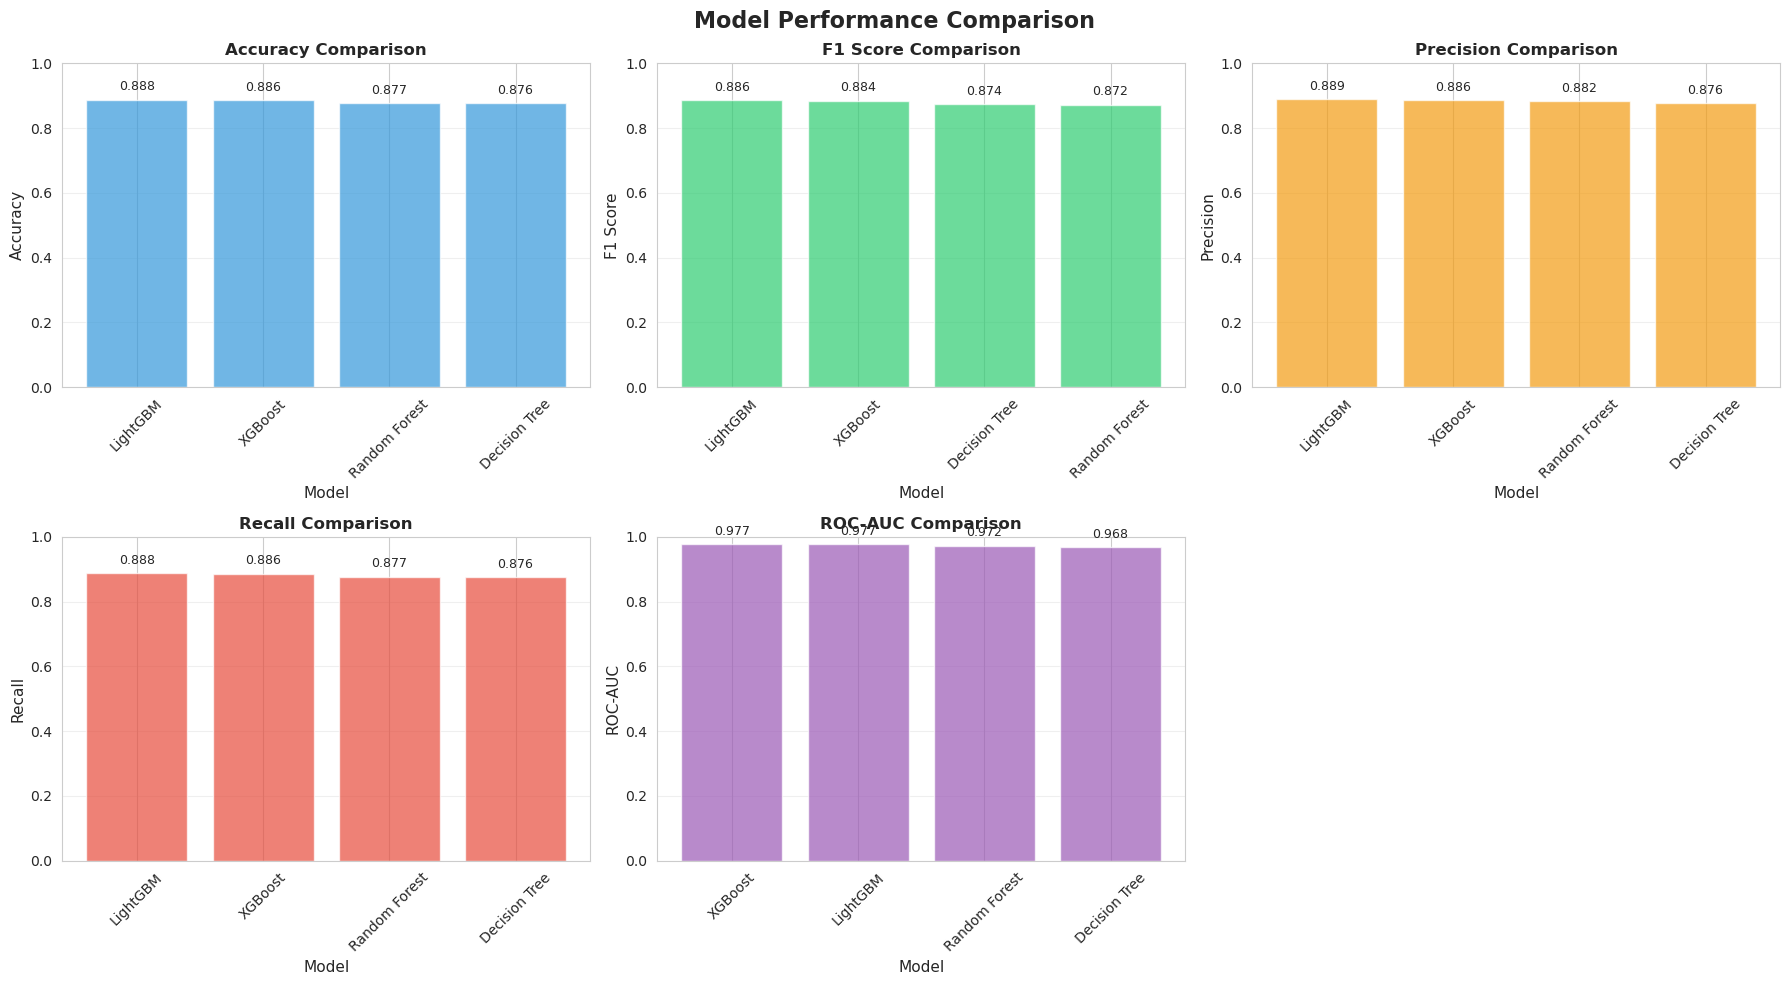

Figure saved: 13_model_comparison.png


In [31]:
# Bar plot of model metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC-AUC']
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    
    data = results_df.sort_values(metric, ascending=False)
    ax.bar(data['Model'], data[metric], color=colors[idx], alpha=0.7)
    ax.set_xlabel('Model', fontsize=11)
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(data[metric]):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

# Remove empty subplot
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.savefig(FIGURES_DIR / '13_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: 13_model_comparison.png")

### 5.3 Confusion Matrices

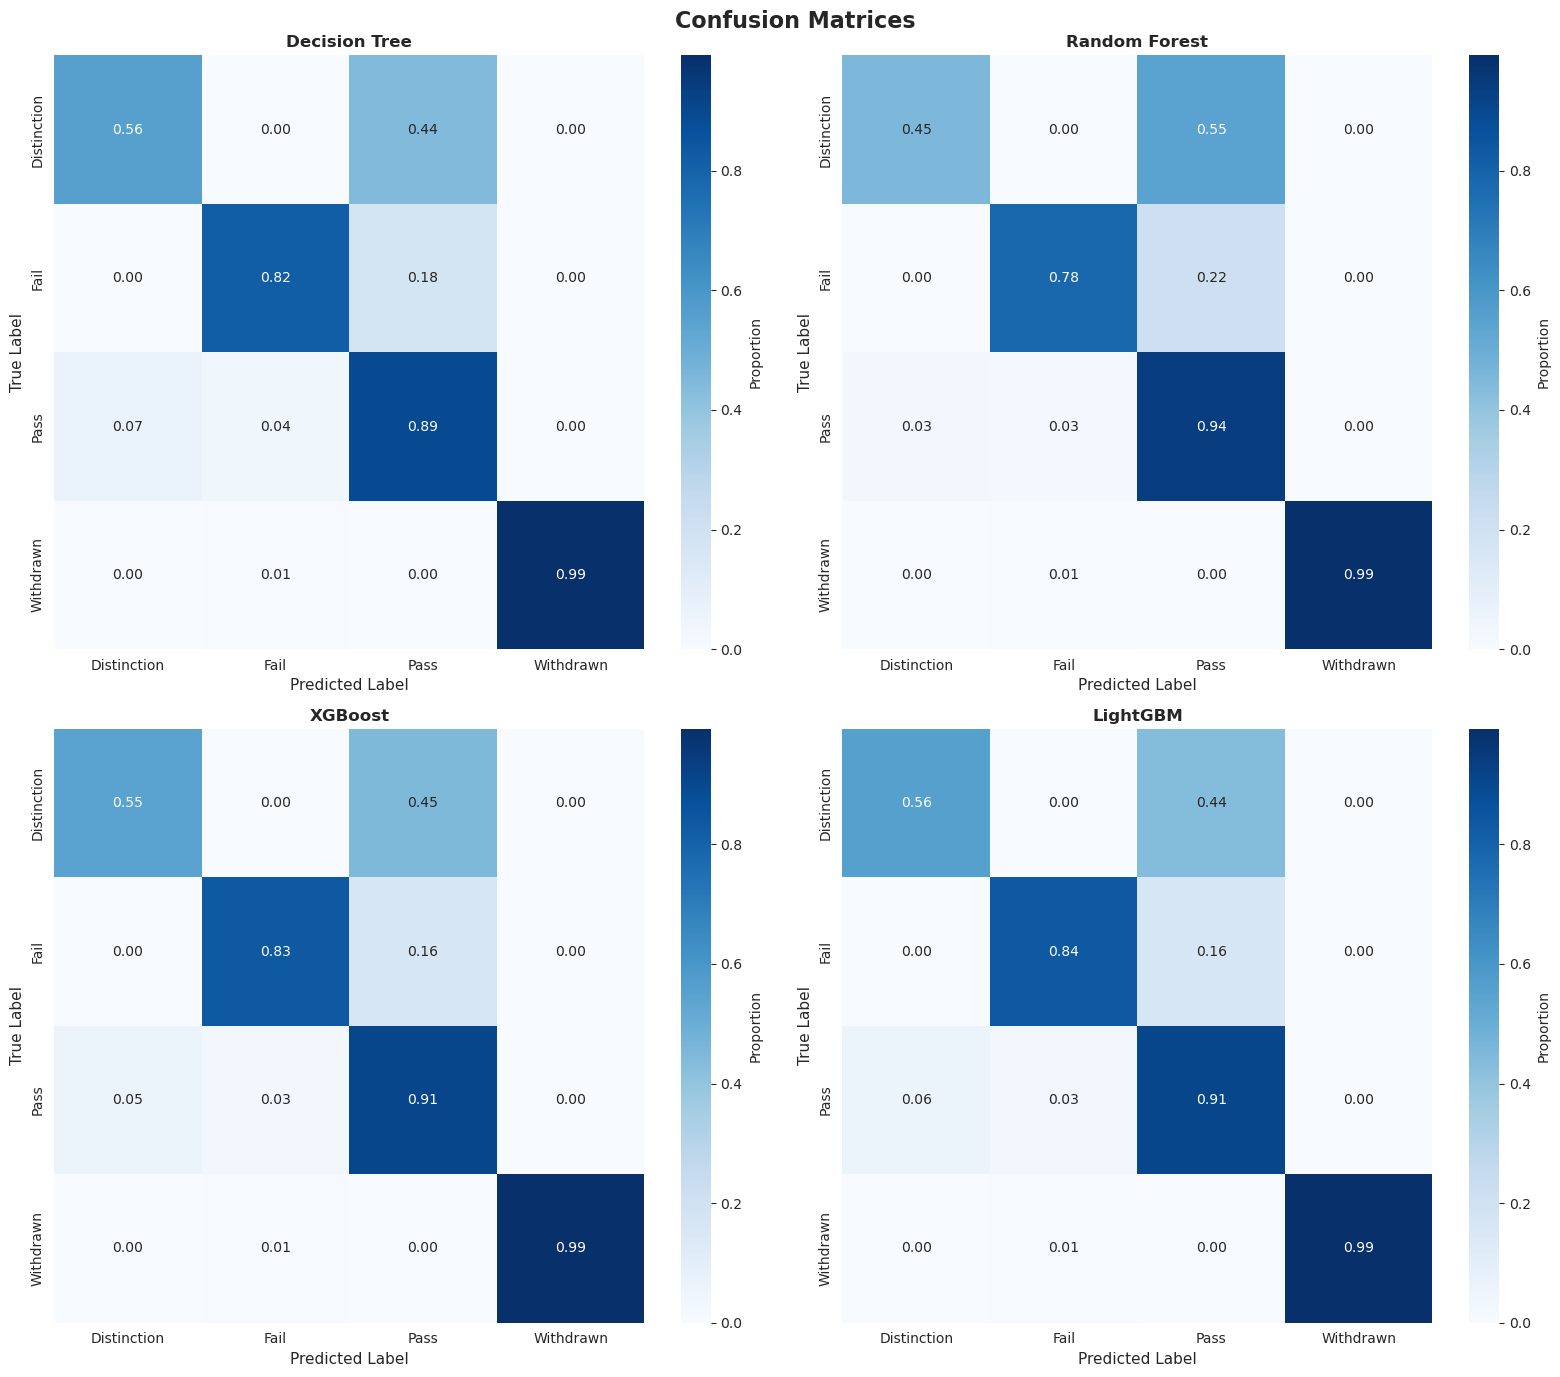

Figure saved: 14_confusion_matrices.png


In [32]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('Confusion Matrices', fontsize=16, fontweight='bold')

for idx, (model_name, model_data) in enumerate(models.items()):
    ax = axes[idx // 2, idx % 2]
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test_np, model_data['y_pred'])
    
    # Normalize by row (true label)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=ax, cbar_kws={'label': 'Proportion'})
    ax.set_xlabel('Predicted Label', fontsize=11)
    ax.set_ylabel('True Label', fontsize=11)
    ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / '14_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: 14_confusion_matrices.png")

### 5.4 ROC Curves (One-vs-Rest)

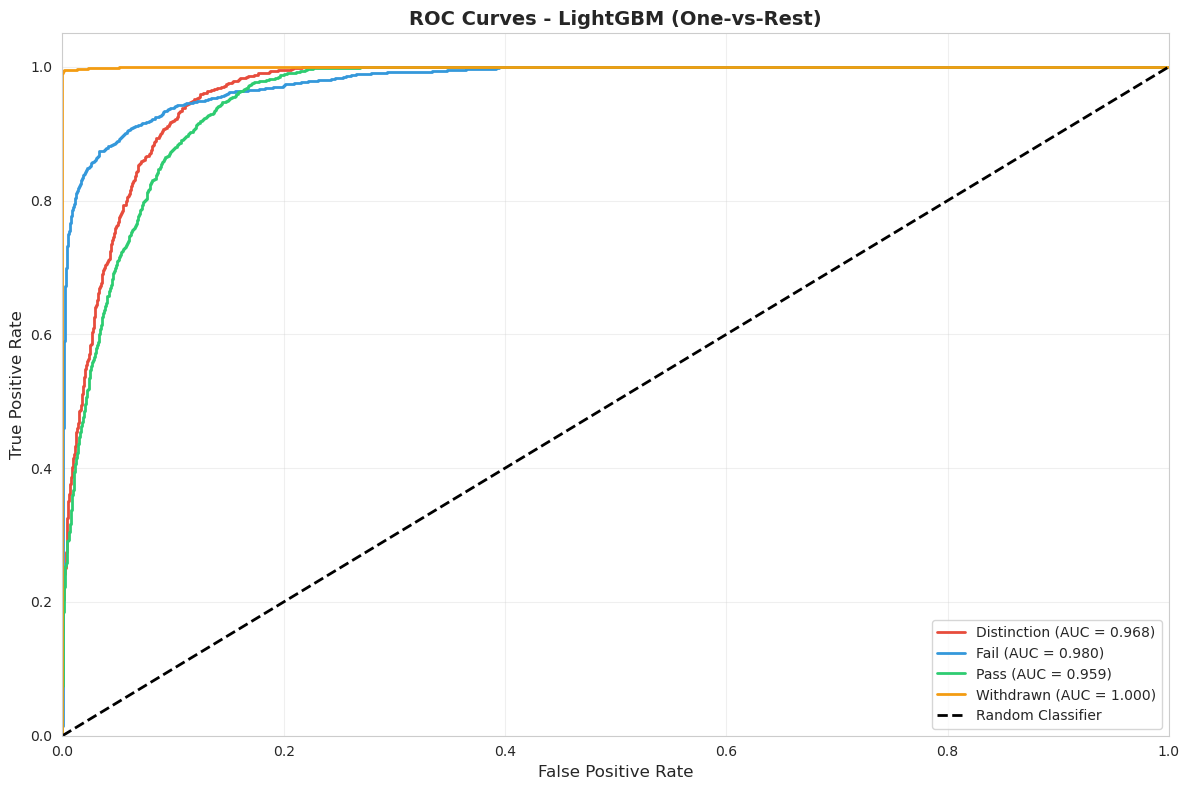

Figure saved: 15_roc_curves.png


In [33]:
# Plot ROC curves for best model (one curve per class)
from sklearn.preprocessing import label_binarize

# Binarize the output
y_test_bin = label_binarize(y_test_np, classes=range(len(class_names)))
n_classes = y_test_bin.shape[1]

# Use best model for ROC curve
best_model_data = models[best_model_name]
y_proba = best_model_data['y_proba']

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(12, 8))
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curves - {best_model_name} (One-vs-Rest)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / '15_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: 15_roc_curves.png")

## 6. Feature Importance Analysis

### 6.1 Feature Importance from Tree Models

In [34]:
# Extract feature importance from tree-based models
feature_importance_dfs = []

for model_name in ['Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM']:
    model = models[model_name]['model']
    
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        
        df_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': importance,
            'model': model_name
        })
        
        feature_importance_dfs.append(df_importance)

# Combine all importance scores
all_importance = pd.concat(feature_importance_dfs, ignore_index=True)

# Average importance across models
avg_importance = all_importance.groupby('feature')['importance'].mean().sort_values(ascending=False)

print("="*80)
print("TOP 20 MOST IMPORTANT FEATURES (AVERAGED ACROSS MODELS)")
print("="*80)
print("\n", avg_importance.head(20).to_string())

TOP 20 MOST IMPORTANT FEATURES (AVERAGED ACROSS MODELS)

 feature
avg_score_TMA                 655.013558
clicks_homepage               653.007156
clicks_oucontent              620.752871
avg_assessment_score          609.282123
clicks_resource               596.503130
clicks_per_activity           593.754706
clicks_forumng                563.253987
clicks_quiz                   530.505399
clicks_subpage                516.753080
total_clicks                  500.758418
avg_score_Exam                475.530380
num_unique_activities         470.008008
clicks_url                    424.002366
assessment_submission_rate    417.606797
avg_score_CMA                 353.254223
clicks_ouwiki                 263.751707
studied_credits               260.001141
total_assessments             247.752804
clicks_oucollaborate          206.751038
num_assessments_submitted     205.772898


### 6.2 Visualize Feature Importance

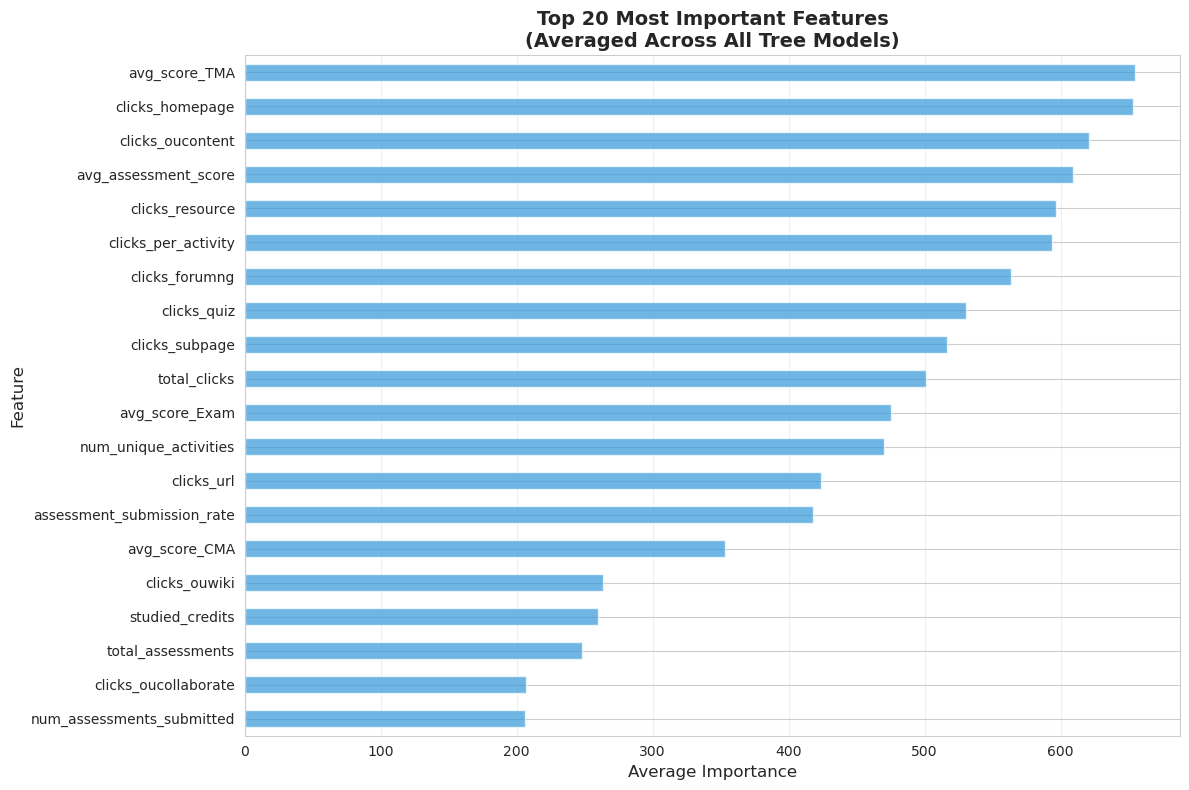

Figure saved: 16_feature_importance.png


In [35]:
# Plot top 20 features by average importance
top_20_features = avg_importance.head(20)

plt.figure(figsize=(12, 8))
top_20_features.plot(kind='barh', color='#3498db', alpha=0.7)
plt.xlabel('Average Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Most Important Features\n(Averaged Across All Tree Models)', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / '16_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: 16_feature_importance.png")

### 6.3 Feature Importance Comparison Across Models

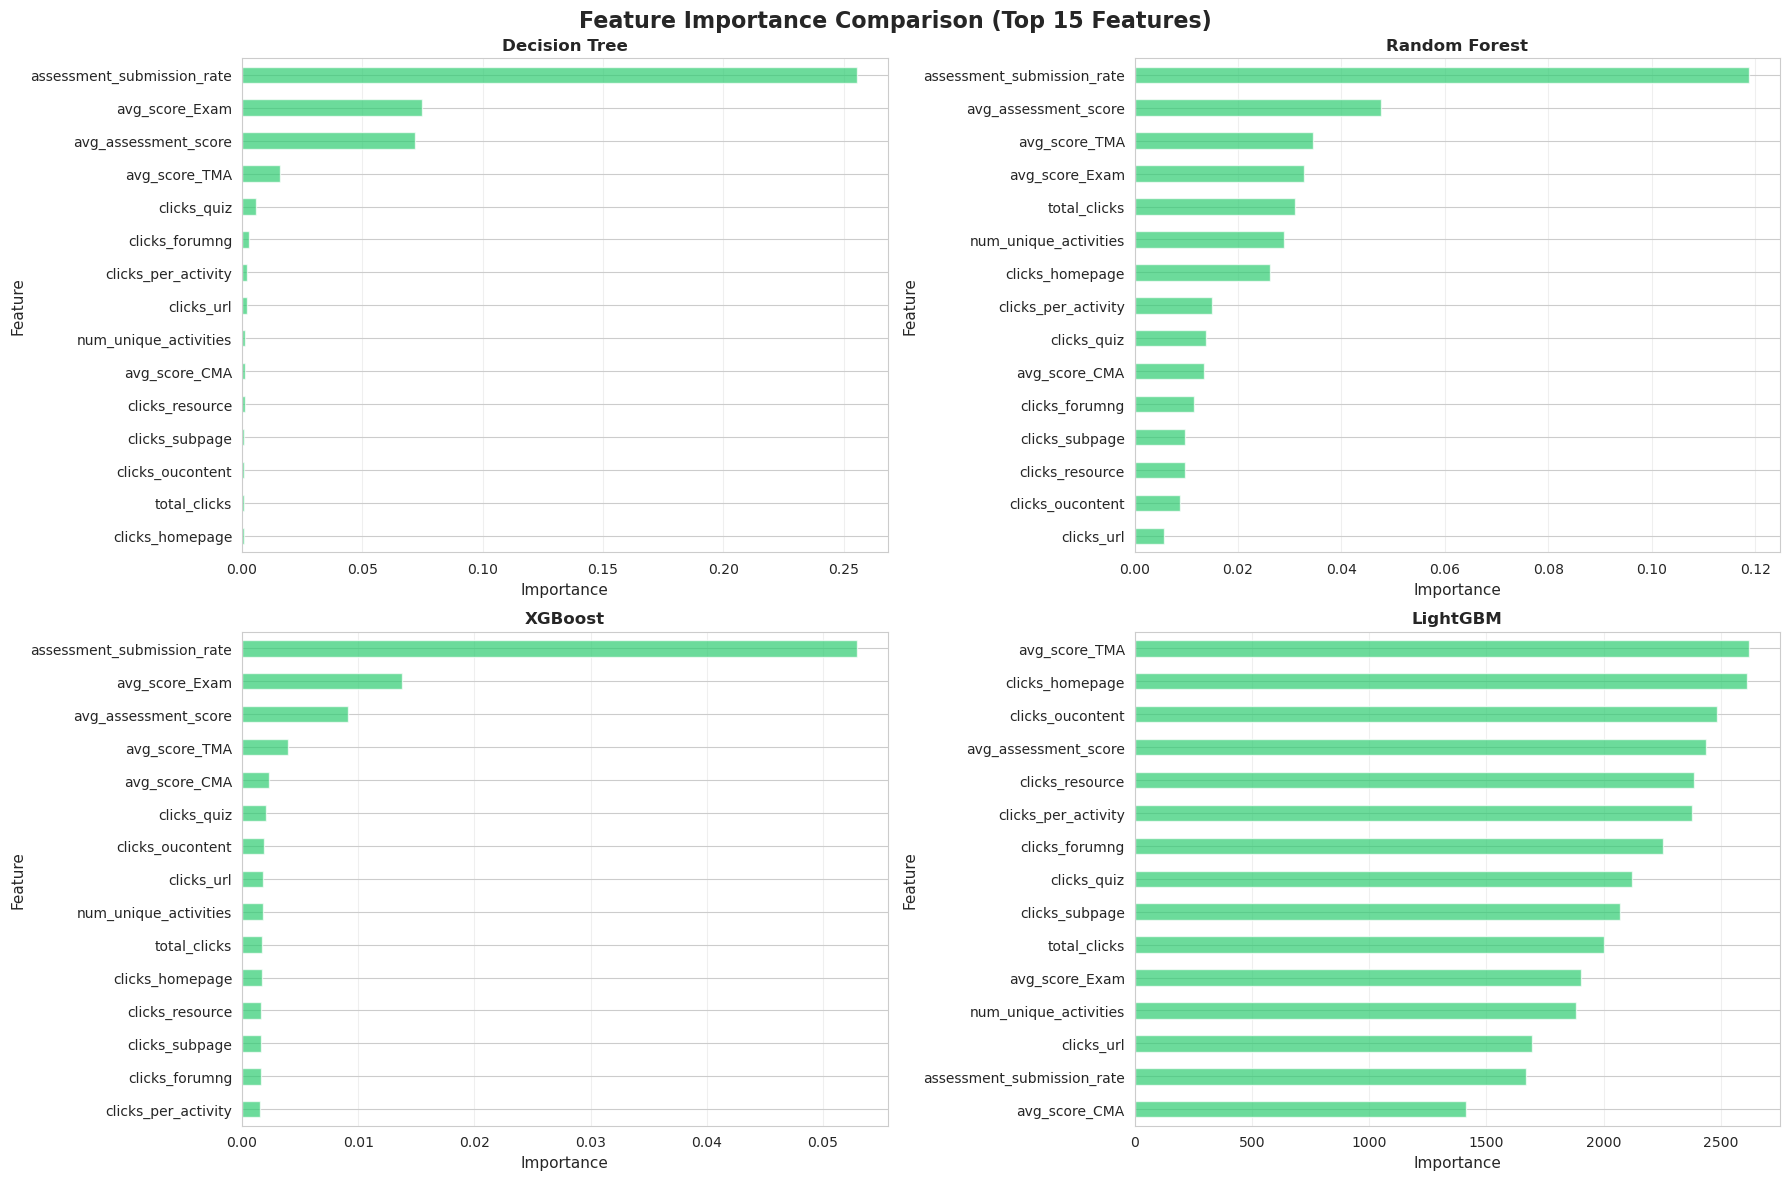

Figure saved: 17_feature_importance_by_model.png


In [36]:
# Plot feature importance for top 15 features across all models
top_15_feature_names = avg_importance.head(15).index

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Feature Importance Comparison (Top 15 Features)', fontsize=16, fontweight='bold')

for idx, model_name in enumerate(['Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM']):
    ax = axes[idx // 2, idx % 2]
    
    # Get importance for this model
    model_importance = all_importance[all_importance['model'] == model_name]
    model_importance = model_importance.set_index('feature')['importance']
    
    # Filter to top 15 features
    model_importance_top = model_importance[top_15_feature_names].sort_values(ascending=True)
    
    # Plot
    model_importance_top.plot(kind='barh', ax=ax, color='#2ecc71', alpha=0.7)
    ax.set_xlabel('Importance', fontsize=11)
    ax.set_ylabel('Feature', fontsize=11)
    ax.set_title(model_name, fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / '17_feature_importance_by_model.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: 17_feature_importance_by_model.png")

## 7. Save Models and Results

### 7.1 Save Trained Models

In [37]:
# Save all models
print("Saving models...")

for model_name, model_data in models.items():
    model = model_data['model']
    filename = model_name.lower().replace(' ', '_') + '_model.pkl'
    filepath = MODELS_DIR / filename
    
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    
    print(f"  ✅ Saved {model_name} to {filepath}")

# Save label encoder
encoder_path = MODELS_DIR / 'label_encoder.pkl'
with open(encoder_path, 'wb') as f:
    pickle.dump(label_encoder, f)
print(f"  ✅ Saved label encoder to {encoder_path}")

# Save feature names (use the original column names from X)
feature_names_path = MODELS_DIR / 'feature_names.pkl'
with open(feature_names_path, 'wb') as f:
    pickle.dump(X.columns.tolist(), f)
print(f"  ✅ Saved feature names to {feature_names_path}")

print("\n✅ All models saved successfully!")

Saving models...
  ✅ Saved Decision Tree to ../models/decision_tree_model.pkl
  ✅ Saved Random Forest to ../models/random_forest_model.pkl
  ✅ Saved XGBoost to ../models/xgboost_model.pkl
  ✅ Saved LightGBM to ../models/lightgbm_model.pkl
  ✅ Saved label encoder to ../models/label_encoder.pkl
  ✅ Saved feature names to ../models/feature_names.pkl

✅ All models saved successfully!


### 7.2 Save Results Summary

In [38]:
# Save results to CSV
results_path = MODELS_DIR / 'model_comparison_results.csv'
results_df.to_csv(results_path, index=False)
print(f"✅ Results saved to {results_path}")

# Save feature importance
importance_path = MODELS_DIR / 'feature_importance.csv'
avg_importance.to_csv(importance_path, header=True)
print(f"✅ Feature importance saved to {importance_path}")

✅ Results saved to ../models/model_comparison_results.csv
✅ Feature importance saved to ../models/feature_importance.csv


## 8. Summary and Next Steps

In [39]:
print("="*80)
print("PHASE 3 COMPLETE")
print("="*80)

print("\n✅ Completed Tasks:")
print("   1. Loaded and prepared dataset from Phases 1 & 2")
print("   2. Encoded features and target variable")
print("   3. Split data into train/test sets (80/20)")
print("   4. Trained Decision Tree classifier")
print("   5. Trained Random Forest classifier")
print("   6. Trained XGBoost classifier")
print("   7. Trained LightGBM classifier")
print("   8. Compared model performance")
print("   9. Analyzed feature importance")
print("   10. Saved all models and results")

print("\n📊 Key Findings:")
print(f"   - Best Model: {best_model_name}")
print(f"   - Best Accuracy: {best_accuracy:.4f}")
print(f"   - Total features used: {len(X.columns)}")
print(f"   - Training samples: {len(X_train):,}")
print(f"   - Test samples: {len(X_test):,}")

print("\n🎯 Model Rankings (by Accuracy):")
for i, row in results_df.iterrows():
    print(f"   {i+1}. {row['Model']}: {row['Accuracy']:.4f}")

print("\n🔝 Top 5 Most Important Features:")
for i, (feature, importance) in enumerate(avg_importance.head(5).items(), 1):
    print(f"   {i}. {feature}: {importance:.4f}")

print("\n🔜 Next Steps (Phase 4):")
print("   1. Conduct feature importance experiments")
print("   2. Test different feature combinations")
print("   3. Perform hyperparameter tuning")
print("   4. Analyze SHAP values for model interpretability")
print("   5. Optimize model performance")

print("\n" + "="*80)

PHASE 3 COMPLETE

✅ Completed Tasks:
   1. Loaded and prepared dataset from Phases 1 & 2
   2. Encoded features and target variable
   3. Split data into train/test sets (80/20)
   4. Trained Decision Tree classifier
   5. Trained Random Forest classifier
   6. Trained XGBoost classifier
   7. Trained LightGBM classifier
   8. Compared model performance
   9. Analyzed feature importance
   10. Saved all models and results

📊 Key Findings:
   - Best Model: LightGBM
   - Best Accuracy: 0.8883
   - Total features used: 67
   - Training samples: 26,074
   - Test samples: 6,519

🎯 Model Rankings (by Accuracy):
   4. LightGBM: 0.8883
   3. XGBoost: 0.8863
   2. Random Forest: 0.8774
   1. Decision Tree: 0.8761

🔝 Top 5 Most Important Features:
   1. avg_score_TMA: 655.0136
   2. clicks_homepage: 653.0072
   3. clicks_oucontent: 620.7529
   4. avg_assessment_score: 609.2821
   5. clicks_resource: 596.5031

🔜 Next Steps (Phase 4):
   1. Conduct feature importance experiments
   2. Test differe